# Piecewise Functions

These are some homecooked methods to fit piecewise functions to data. The usecase is a situation where there is a transition from one data generating process to the other. The goal is then to fit the process parameter and to also identify the transition point.

I have previously done this sort of thing using MCMC. Namely, I used PyMC3 to fit a regression with a breakpoint like so: https://stackoverflow.com/questions/36045851/pymc3-regression-with-change-point/36114952 . 

MCMC inference is nice, but I'd like to take an approach that involves less machinery.

Goal is to fit a "V" shape.

Problem it is that the derivative doesn't exist at the "kink". I will try to use a Fermi-Dirac Distribution as a smooth approximation to a Heaviside function.  

Leaving the temperature a trainable parameter actually allows for smooth breakpoints, which could be kind of cool. I'll skip that for now.

Overflow issues in the exponential functions require prescaling. 

Apart from that, this works o.k. for two linear spines! 

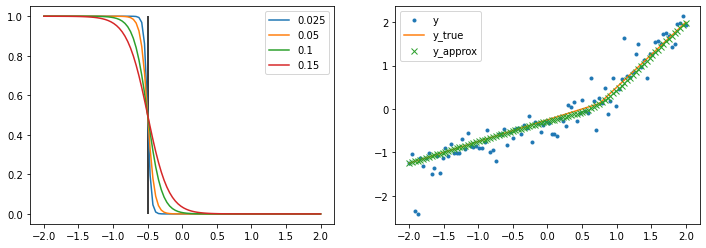

In [76]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(45)

def f_true(x,a,b1,b2,m):
    y = np.zeros(shape=x.shape)
    y[x < m] = a + b1*x [x < m]
    y[x >= m] = a + (b1-b2)*m + b2*x[x >= m]
    return y
    
def fermi_dirac(x,mu,T):
    return 1/(np.exp((x-mu)/T) + 1)

def f_approx(x,a,b1,b2,m,T):
    return fermi_dirac(x,m,T)*(a+b1*x) + fermi_dirac(-x,-m,T)*(a+(b1-b2)*m+b2*x)



# Fermi-Diract Distributions
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
mu = -0.5
Ts = [0.025,0.05,0.1,0.15]
for T in Ts:
    ax1.plot(x,fermi_dirac(x,mu,T))
      
ax1.legend(Ts)
ax1.vlines(x=mu,ymin=0,ymax=1)


# Data, true + approx
a = -0.25
b1 = 0.5
b2 = 1.5
m = 0.75


x = np.linspace(-2,2,100)
y = f_true(x,a,b1,b2,m) + 0.2*np.random.standard_t(df=2,size=x.shape)
y_true = f_true(x,a,b1,b2,m)
y_approx = f_approx(x,a,b1,b2,m,0.25)

ax2 = fig.add_subplot(122)
ax2.plot(x,y,'.')
ax2.plot(x,y_true)
ax2.plot(x,y_approx,'x')
ax2.legend('y,y_true,y_approx'.split(','))

Text(0.5, 1.0, 'Loss')

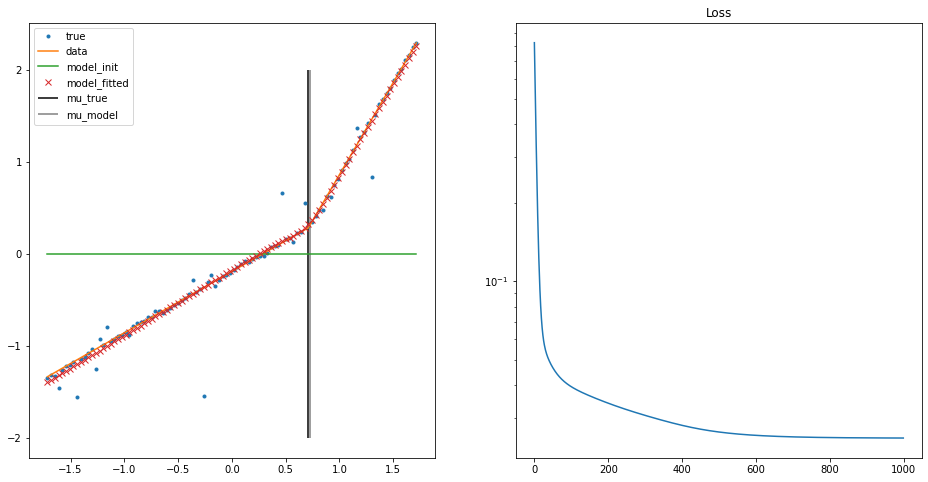

In [441]:
class BreakPointRegression(object):
    
    def __init__(self,loss_p=2,temperature=0.05):
        # loss metric
        self.loss_p = loss_p
        
        # learning rate 
        self.learning_rate = 10
        
        # initalize parameters 
        self.a = 0#np.random.randn()
        self.b1 = 0#np.random.randn()
        self.b2 = 0#np.random.randn()
        self.mu = 0#np.random.randn()
        self.T = temperature
        
    
    """model functions"""
    def fermi_pre(self,x):
        # 1 for x << mu; 0 for x >> mu
        return 1/(np.exp((x-self.mu)/np.abs(self.T)) + 1)
    
    def fermi_post(self,x):
        # 0 for x << mu; 1 for x >> mu
        return 1/(np.exp((-x+self.mu)/np.abs(self.T)) + 1)
    
    def f_pre(self,x):
        # function pre breakpoint
        return self.a + self.b1*x
    
    def f_post(self,x):
        # function post breakpoint
        return self.a+(self.b1-self.b2)*self.mu+self.b2*x
    
    def predict(self,x):
        # full model
        return self.fermi_pre(x)*self.f_pre(x) + self.fermi_post(x)*self.f_post(x)
    
    """loss"""
    def loss(self,x,y):
        # loss 
        return np.mean(np.abs(self.predict(x)-y)**self.loss_p)
    
    """loss gradient"""
    def L_prime(self,x,y):
        # generic first derivative of loss 
        eps = self.predict(x)-y
        Lp = self.loss_p*np.abs(eps)**(self.loss_p-1)*np.sign(eps)/len(eps)
        
        assert Lp.shape == x.shape
        
        return Lp
    
    def df_da(self,x):
        return self.fermi_pre(x)+self.fermi_post(x)
    
    def df_db1(self,x):
        return x*self.fermi_pre(x) + self.mu*self.fermi_post(x)
    
    def df_db2(self,x):
        return (x-self.mu)*self.fermi_post(x)
    
    def fermi_pre_prime(self,x):
        return self.fermi_pre(x)**2 * np.exp((x-self.mu)/self.T)/self.T
    
    def fermi_post_prime(self,x):
        return -self.fermi_post(x)**2 * np.exp((self.mu-x)/self.T)/self.T
    
    def df_dmu(self,x):
        return ( (self.a+self.b1*x)*self.fermi_pre_prime(x) 
                + (self.b1-self.b2)*self.fermi_post(x) 
                + (self.a+self.mu*(self.b1-self.b2)+self.b2*x)*self.fermi_post_prime(x)
               )
        
    
    def gradient(self,x,y):
        # gradient of loss function [a,b1,b2,mu]
        Lp = self.L_prime(x,y)
        return [
            np.mean(Lp*self.df_da(x)),
            np.mean(Lp*self.df_db1(x)),
            np.mean(Lp*self.df_db2(x)),
            np.mean(Lp*self.df_dmu(x))
        ]
    
    """parameter update"""
    def gradient_descent(self,x,y):
        
        gradient = self.gradient(x,y)
        
        self.a = self.a - self.learning_rate * gradient[0]
        self.b1 = self.b1 - self.learning_rate * gradient[1]
        self.b2 = self.b2 - self.learning_rate * gradient[2]
        self.mu = self.mu - self.learning_rate * gradient[3]
            
    """fit with gradient descend"""
    def fit(self,x,y,iters=100,verbose=True):
        
        #self.a = np.min(y)
        #self.b1 = (np.max(y)-np.min(y))/(np.max(x)-np.min(x))
        #self.b2 = self.b1
        #self.mu = (np.max(x)-np.min(x))/2
        
        self.loss_log = []
        for i in range(iters):
            self.gradient_descent(x,y)
            
            if verbose:
                self.loss_log.append(self.loss(x,y))
                # print(self.loss_log[-1])
                
                
            
            
from sklearn.preprocessing import StandardScaler

# Data, true + approx
a = -0.25
b1 = 0.5
b2 = 1.5
m = 20.75

x = np.linspace(-50,50,100)
y_true = f_true(x,a,b1,b2,m)
y = y_true + 0.25*np.random.standard_t(df=1,size=x.shape)

ScalerX = StandardScaler()
ScalerY = StandardScaler()

x = ScalerX.fit_transform(x.reshape(-1,1))
y = ScalerY.fit_transform(y.reshape(-1,1))
y_true = ScalerY.transform(y_true.reshape(-1,1))

model = BreakPointRegression()   

fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121)
ax1.plot(x,y,'.')
ax1.plot(x,y_true)
ax1.plot(x,model.predict(x))

model.T = 0.1
model.loss_p = 2
model.fit(x,y,iters=1000)

ax1.plot(x,model.predict(x),'x')
ax1.vlines(x=ScalerX.transform(np.array(m).reshape(1,-1)),ymin=-2,ymax=2,color='black')
ax1.vlines(x=model.mu,ymin=-2,ymax=2,color='gray')
ax1.legend('true,data,model_init,model_fitted,mu_true,mu_model'.split(','))

ax2 = fig.add_subplot(122)
ax2.semilogy(model.loss_log)
ax2.set_title('Loss')

Text(0, 0.5, 'error')

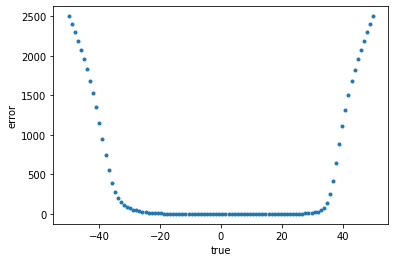

In [397]:
# what happens for off center m? 

# case for noiseless data

# Data, true + approx
a = 0
b1 = -2
b2 = 2

x = np.linspace(-50,50,100)

m_true = np.linspace(-50,50,100)
m_fitted = []
b1_fitted = []
b2_fitted = []
a_fitted = []
for mx in m_true:
    y_true = f_true(x,a,b1,b2,mx)
    y = y_true # + 0.25*np.random.standard_t(df=100,size=x.shape)

    ScalerX = StandardScaler()
    ScalerY = StandardScaler()

    x_ = ScalerX.fit_transform(x.reshape(-1,1))
    y = ScalerY.fit_transform(y.reshape(-1,1))
    y_true = ScalerY.transform(y_true.reshape(-1,1))
    
    model = BreakPointRegression()
    model.fit(x_,y,iters=500)
    
    m_fitted.append(ScalerX.inverse_transform(np.array(model.mu).reshape(1,-1))[0][0])
    a_fitted.append(ScalerY.inverse_transform(np.array(model.a).reshape(1,-1))[0][0])
    
    ScalerX.var_[0]
    
    b1_fitted.append(model.b1*ScalerY.var_[0]/ScalerX.var_[0])
    b2_fitted.append(model.b2*ScalerY.var_[0]/ScalerX.var_[0])
    

plt.plot(m_true,(m_true-m_fitted)**2,'.')

plt.xlabel('true'); plt.ylabel('error')

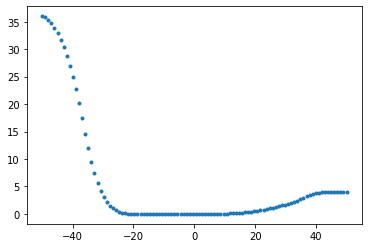

In [398]:
plt.plot(m_true,(np.array(b1_fitted)-b1)**2,'.')

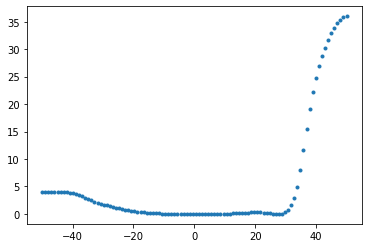

In [399]:
plt.plot(m_true,(np.array(b2_fitted)-b2)**2,'.')

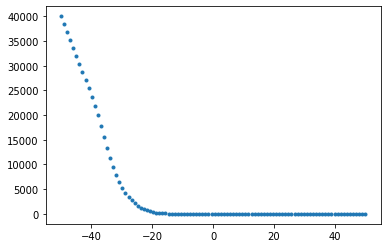

In [400]:
plt.plot(m_true,(np.array(a_fitted)-a)**2,'.')

# Edge Detection

What about a sliding window, where a "hill" gradually comes into view? 

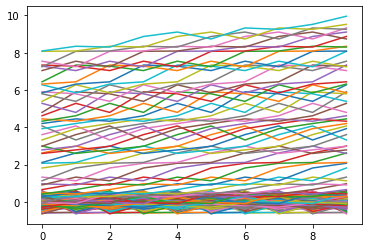

In [436]:
x = np.linspace(-50,50,100)


# Data, true + approx
a = 0
b1 = 0
b2 = 2
m = 5

x = np.linspace(-10,10,200)
y_true = f_true(x,a,b1,b2,m)
y = y_true  + 0.25*np.random.standard_t(df=100,size=x.shape)

m_fitted = []
b1_fitted = []
b2_fitted = []
a_fitted = []

def get_windows(x,y,size):
    for i in range(len(x)-size):
        yield x[i:i+size],y[i:i+size]

windows = get_windows(x,y,size=10)

for x_win,y_win in windows:

    x_win = np.array(list(range(len(y_win))))
    
    ScalerX = StandardScaler()
    ScalerY = StandardScaler()

    x_ = ScalerX.fit_transform(x_win.reshape(-1,1))
    y = ScalerY.fit_transform(y_win.reshape(-1,1))
    y_true = ScalerY.transform(y_true.reshape(-1,1))
    
    model = BreakPointRegression()
    model.fit(x_,y,iters=500,verbose=False)
    
    m_fitted.append(ScalerX.inverse_transform(np.array(model.mu).reshape(1,-1))[0][0])
    a_fitted.append(ScalerY.inverse_transform(np.array(model.a).reshape(1,-1))[0][0])
    b1_fitted.append(model.b1*ScalerY.var_[0]/ScalerX.var_[0])
    b2_fitted.append(model.b2*ScalerY.var_[0]/ScalerX.var_[0])
    
    plt.plot(x_win,y_win)

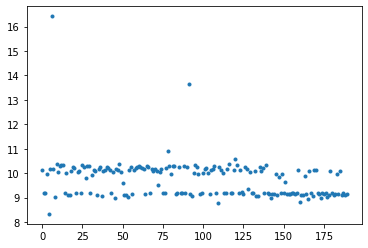

In [437]:
plt.plot(m_fitted,'.')

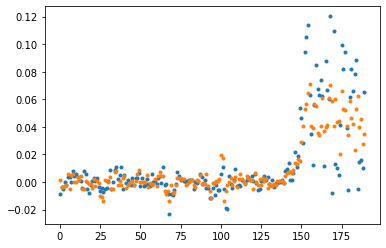

In [438]:
plt.plot(b1_fitted,'.')
plt.plot(b2_fitted,'.')

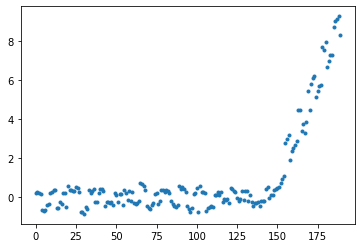

In [439]:
plt.plot(range(len(a_fitted)),a_fitted,'.')

# Uncertainty Estimates

Bootstrap